## Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### Import the Necessary Packages

In [3]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

### Instantiate the Environment and Agent

Initialize the environment.

In [4]:
import sys
# sys.path.append(r"c:\users\admin\appdata\local\programs\python\python311\lib\site-packages")
# !pip install gymnasium
import gymnasium as gym
# !pip install swig
# !pip install "gymnasium[box2d]"

In [5]:
env = gym.make('LunarLander-v3')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Define Neural Network Architecture.

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state #cac thong tin ve state hien tai
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)
    #output: a vector with Q-values

### Define some hyperparameter

In [16]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Agent

In [18]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)  #update after each step
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device) #update after few steps
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed) #tránh phụ thuộc quá nhiều vào các bước gần nhau.
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define Replay Buffer

In [19]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = np.array(state[0])
        state = state.reshape(1, -1)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=210.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 62	Average Score: -176.88

KeyboardInterrupt: 

### Plot the learning progress

NameError: name 'scores' is not defined

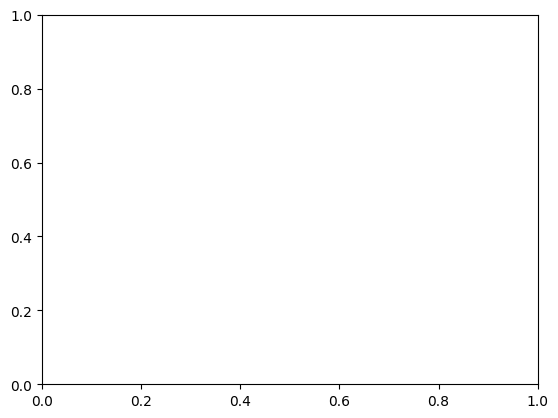

In [20]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [21]:
#Evaluate:
def evaluate(n_episodes=10, max_t=1000):
    scores = []
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps=0.0)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
    return scores

scores = evaluate()
print("Average Score: {:.2f}".format(np.mean(scores)))

Average Score: -826.80


In [30]:
import gymnasium as gym
import torch
import imageio
import numpy as np
# Ensure your Agent class and dependencies are properly imported

# Define constants
ENV_NAME = "LunarLander-v3"
MODEL_PATH = "checkpoint.pth"  # Path to your saved model
VIDEO_FILENAME = "lunar_lander_solution_3.mp4"
EPISODES = 1  # Number of episodes to record

# Initialize environment and agent
env = gym.make(ENV_NAME, render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size, seed=0)

# Load the trained weights
agent.qnetwork_local.load_state_dict(torch.load(MODEL_PATH))

frames = []  # Store video frames

# Run the environment
total=0
frame_counter=0
for _ in range(EPISODES):
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.act(state, eps=0.0)  # Use the trained policy
        state, reward, done, truncated, _ = env.step(action)
        # Capture the frame
        frame = env.render()
        frames.append(frame)
        total += reward
        frame_counter += 1
        print("Step: ", frame_counter, ", reward", reward, ", current reward: ", total)

# Save video using imageio
imageio.mimsave(VIDEO_FILENAME, frames, fps=30)
print(f"Video saved as {VIDEO_FILENAME}")

# Close the environment
env.close()


C:\Users\HP\AppData\Local\Temp\ipykernel_10896\3265657965.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.qnetwork_local.load_state_dict(torch.load(MODEL_PATH))


Step:  1 , reward 0.32051452851155315 , current reward:  0.32051452851155315
Step:  2 , reward 0.35027390716015927 , current reward:  0.6707884356717124
Step:  3 , reward 0.21314895462936193 , current reward:  0.8839373903010743
Step:  4 , reward -0.6313111948772985 , current reward:  0.25262619542377585
Step:  5 , reward -0.7063595712605206 , current reward:  -0.4537333758367448
Step:  6 , reward 0.2514437734025432 , current reward:  -0.20228960243420158
Step:  7 , reward -1.353444088842366 , current reward:  -1.5557336912765676
Step:  8 , reward -1.393001899715813 , current reward:  -2.9487355909923805
Step:  9 , reward -1.4220960484726959 , current reward:  -4.370831639465076
Step:  10 , reward -1.4416521117933883 , current reward:  -5.812483751258465
Step:  11 , reward -1.4527605947481845 , current reward:  -7.265244346006649
Step:  12 , reward -1.4563521563788697 , current reward:  -8.72159650238552
Step:  13 , reward -1.4532830127523368 , current reward:  -10.174879515137857
Step

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Step:  253 , reward -2.0735944068332515 , current reward:  118.70016974113777
Step:  254 , reward -0.3569522993889322 , current reward:  118.34321744174883
Step:  255 , reward -0.46139640757504025 , current reward:  117.8818210341738
Step:  256 , reward 3.7142255104679593 , current reward:  121.59604654464175
Step:  257 , reward -1.9649417342940936 , current reward:  119.63110481034767
Step:  258 , reward -0.8950227315863615 , current reward:  118.7360820787613
Step:  259 , reward -0.3505000435847549 , current reward:  118.38558203517654
Step:  260 , reward -1.9577731068773474 , current reward:  116.42780892829919
Step:  261 , reward 2.7500526894393564 , current reward:  119.17786161773854
Step:  262 , reward -1.860676862208825 , current reward:  117.31718475552972
Step:  263 , reward 2.399709918337387 , current reward:  119.71689467386712
Step:  264 , reward -1.857872732854041 , current reward:  117.85902194101308
Step:  265 , reward -0.03888767598378279 , current reward:  117.8201342